<a href="https://www.kaggle.com/code/avikumart/computervision-intel-image-classification-project?scriptVersionId=101630044" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

In this notebook, we will build image classification models to classify 6 categories of images; namely buildings, forest, glacier, mountain, sea, and street.

**Problem statement:** Build model that classifies 6 categories images from intel images dataset accuratly 

**Steps to be followed to solve this problem:**
1. load the dataset
2. label the dataset
3. visualize and explore the dataset
4. train the Deep neural net with CNN layer
5. train using pre-trained models from keras models

*this notebook is under progress*

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
from skimage.io import imread, imshow

# 1. Label and load the dataset

In [2]:
train_dir = '../input/intel-image-classification/seg_train/seg_train'
test_dir = '../input/intel-image-classification/seg_test/seg_test'
pred_dir = '../input/intel-image-classification/seg_pred/seg_pred'

In [3]:
# assign class labels
class_names = ['buildings','forest','glacier','mountain','sea','street']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}
print(class_labels)

number_classes = len(class_names)

IMAGE_SIZE = (150,150)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [4]:
# usecase of os.listdir and os.path.join functions
for folder in os.listdir(train_dir):
    files_path = []
    for file in os.listdir(os.path.join(train_dir,folder)):
        files_path.append(file)
    print(len(files_path))

2512
2382
2191
2274
2271
2404


In [5]:
# define load_dataset function to load dataset with labels
def load_dataset():
    # create list of datasets
    datasets = [train_dir, test_dir]
    output = []
    
    for dataset in datasets:
        
        images1 = []
        labels1 = []
        print(f"loading {dataset}")
        
        for folder in os.listdir(dataset):
            # assign labels to each folder images
            label = class_labels[folder]
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                image_path = os.path.join(os.path.join(dataset, folder), file)
                # read the image files stored in image_path
                image_file = cv2.imread(image_path)
                image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
                image_file = cv2.resize(image_file, IMAGE_SIZE)
                
                images1.append(image_file)
                labels1.append(label)
            
        images1 = np.array(images1, dtype = 'float32')
        labels1 = np.array(labels1, dtype = 'int32')
        
        output.append((images1, labels1))
        print("Images file have been loaded")
                
    return output     

In [6]:
# load the data using above functions
((train_images, train_labels), (test_images, test_labels)) = load_dataset()

loading ../input/intel-image-classification/seg_train/seg_train


100%|██████████| 2404/2404 [00:15<00:00, 155.03it/s]


Images file have been loaded
loading ../input/intel-image-classification/seg_test/seg_test


100%|██████████| 553/553 [00:02<00:00, 186.02it/s]


Images file have been loaded


In [7]:
print("train dataset size")
len(train_images), len(train_labels)

train dataset size


(14034, 14034)

In [8]:
print("test dataset size")
len(test_images), len(test_labels)

test dataset size


(3000, 3000)

# 2. Pre-process and explore image datasets

In [9]:
# shape of image dataset is 4D tensors
train_images.shape, test_images.shape

((14034, 150, 150, 3), (3000, 150, 150, 3))

In [10]:
# shuffle the train nad test datasets
(train_images, train_labels) = shuffle(train_images, train_labels, random_state=45)

In [11]:
(test_images, test_labels) = shuffle(test_images, test_labels, random_state=45)

In [12]:
# reduce the sizee of dataset due to memory issue
trn_images = train_images[:7000]
trn_labels = train_labels[:7000]

In [13]:
tst_images = test_images[:1500]
tst_labels = test_labels[:1500]

In [14]:
# normalize the images dataset
trn_images_norm = trn_images/255.0 
tst_images_norm = tst_images/255.0 

In [15]:
# let's see proportion of classes in train and test dataset
def proportion_labels(labels, dataset):
    series = pd.DataFrame(labels).reset_index()
    series.rename(columns = {0:'labels'}, inplace=True)
    final_s = series.groupby('labels').count().reset_index()                                          
    ticks1= [key for key in class_labels.keys()]
    
    # plot the pie chart and bar graph of labels
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.bar(np.array(final_s['labels']), np.array(final_s['index']))
    plt.xticks(ticks=np.array(final_s['labels']), labels=ticks1, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.grid(visible=True)
    plt.title("Number of images per class", size=14, weight='bold')
    
    plt.subplot(122)
    plt.pie(final_s['index'].ravel(),
            labels=ticks1,
            autopct='%1.2f%%',
            textprops={'fontweight':'bold'}
           )
    plt.title("proportion of classes", size=14, weight='bold')
    
    plt.suptitle(f"Proportion of {dataset} data", size=20, weight='bold')
    plt.show()
    
    return final_s

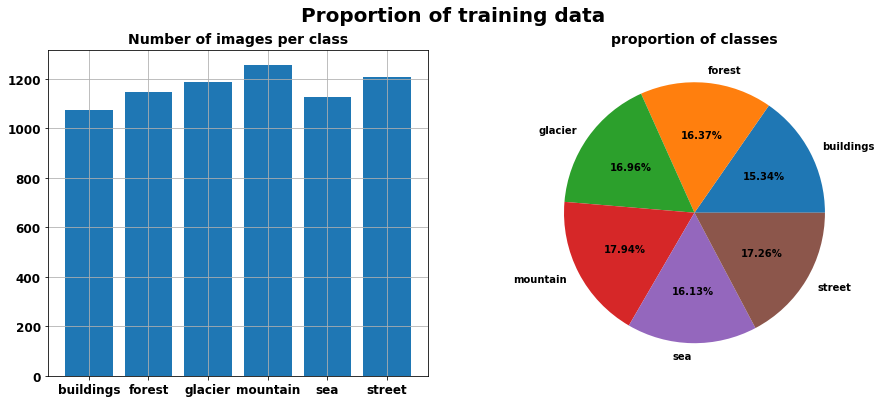

In [16]:
final_s = proportion_labels(trn_labels, "training")

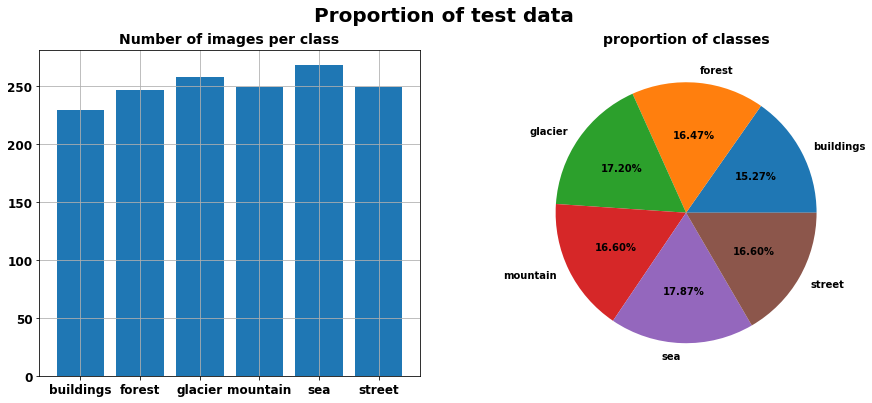

In [17]:
test_d = proportion_labels(tst_labels, "test")

**NOTE:**

**Our both training and test datasets are more or less equally distributed as we shuffled the dataset after loading and labeling**

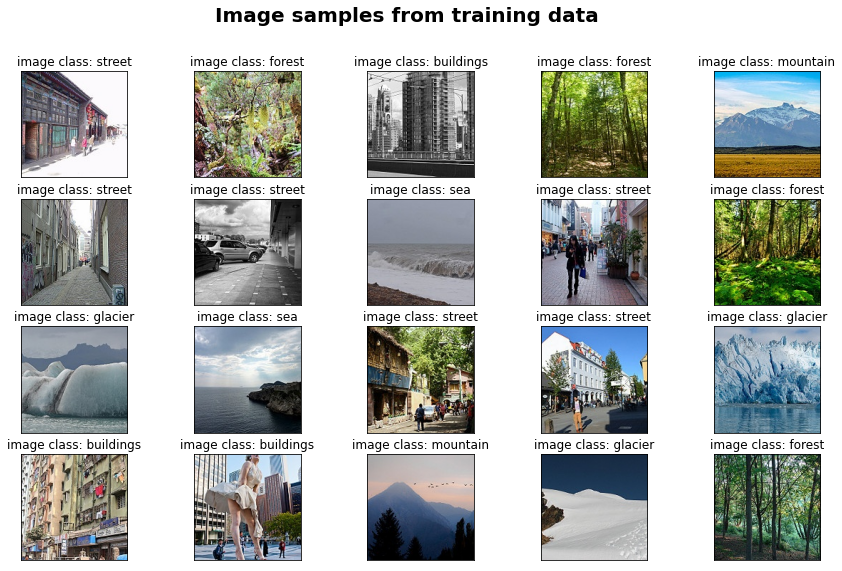

In [18]:
## plot 3*5 visualization of images
plt.figure(figsize=(15,9))
for idx, label in enumerate(trn_labels[:20]):
    plt.subplot(4,5, idx+1)
    plt.imshow(trn_images_norm[idx])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'image class: {class_names[label]}')   
    
plt.suptitle(f'Image samples from training data', size=20, weight='bold')
plt.show()

In [19]:
#  build CNN model to classify the images dataset